## AUTOHALLUSION Demo: Paired Object Insertion 

AUTOHALLUSION using paired object insertion strategy, objects, including both target and disturbing objects (objects correlated but not inserted), and scene images could be either generated with synthetic strategy or using the user's input images or object names.

In [1]:
import numpy as np
import time
import logging, sys, os, json, shutil
from tqdm import tqdm
import traceback 
import random
from PIL import Image

from utils.utils_merge import import_functions_given_model_type, load_cfg_given_model_type
from utils.utils_eval import evaluation_existence_given_pred_model, evaluation_spatial_relation_give_pred_model, evaluation_correlated_existence_pred_model
from utils.utils import (OwlViTProcessor, OwlViTForObjectDetection, scene_thinking, generate_image_given_scene,
                         Addition_Image_Operation_VD_stitch_correlation, object_detection, spatial_gt_generation,
                         resize_img_n_store, convert_into_sequare)

C:\ProgramData\Anaconda3\envs\nips\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hyper-Parameters

Hyper-parameters to set up the experiments, including the queried model type, the inserted object size and the constrains to generate the object and scene image.

In [2]:
# Experiment tag to store data
exp_tag = 'paired_obj_insertion'
exp_name = "exi_exp_{}".format(exp_tag)
use_dataset = False # Using Synthetic Data

scene_constrain = None # Add constraints on the scene themes
irrelevant_obj_category = None # Add constraints on the object to be inserted

obj_count = 5 # Number of correlated objects generation within the scene image

# Specify the model type among:
# 'gemini', 'claude', 'gpt4v', 'llava', 'minigpt4'
obj_think_model_type, img_caption_model_type = 'gpt4v', 'gpt4v'

# Folder to store the experiment data and logs
exp_dir = "./exp_{}_{}_{}_use_dataset-{}".format(exp_tag, obj_think_model_type, img_caption_model_type, use_dataset)

save_dir = "{}/{}/".format(exp_dir, exp_name)

attribute_category_list = []

object_size = (200, 200) # Object size (Abnormal / Paired Object Insertion)
scene_img_raw_size = None

# Ablation study: Object-Scene Alignment (for Abnormal Object Insertion)
# Initial: Intentionally choose abnormal object to insert into the scene
obj_random = False # Using random object to insert
scene_ramdom = False # Randomly shuffle the scene images
same = False # Using objects within the same context to insert

In [3]:
# Alternative Option: using images generated previously as the scene/object/result image
exteral_path = "demo//showcases//paired_obj_insertion"

In [4]:
# Load functions from the utils
(
    generate_noun_given_scene_aimodel,
    random_obj_thinking_aimodel,
    irrelevant_obj_thinking_aimodel,
    gt_generation_aimodel,
    gt_generation_multi_obj_removal_aimodel,
    image_caption_aimodel,
    vqa_aimodel,
    filter_remove_obj_under_scene_aimodel,
    filter_most_irrelevant_aimodel,
    list_objects_given_img_aimodel,
    correlated_obj_thinking_aimodel,
    correlated_example_create_aimodel,
    safe_remove_dir,
    close_logger
) = import_functions_given_model_type(obj_think_model_type, img_caption_model_type)


temp_generate_noun_given_scene, temp_filter_remove_obj_under_scene, temp_filter_most_irrelevant, \
temp_random_obj_thinking, temp_irrelevant_obj_thinking, temp_correlated_obj_thinking = load_cfg_given_model_type(obj_think_model_type)

verbose... model_type import_functions_given_obj_think_model_type gpt4v
verbose... model_type import_functions_given_img_caption_model_type gpt4v
verbose...load_cfg_given_obj_think_model_type given model_type gpt4v: temp_generate_noun_given_scene 0.2, temp_filter_remove_obj_under_scene 1.5, temp_filter_most_irrelevant 0.2, temp_random_obj_thinking 1.5, temp_irrelevant_obj_thinking 1.5, temp_correlated_obj_thinking 1.5


### Phase 1: Synthetic Image Generation

Generate scene images and object images using the image generation model like Dall-E-3, with sufficient context information included in the image.

In [5]:
# Initialize the timestamps and storage path for images generated
case_name = str(int(time.time()))
save_loc = save_dir + "{}/".format(case_name)

init_img_path = "init.png"
result_img_path = "results.png"

if not os.path.exists(save_loc):
    os.makedirs(save_loc)

# Initialize the images (initial and AutoHallusion) for storage
log_path = os.path.join(save_loc, "output.log")
init_img_path = os.path.join(save_loc, init_img_path)
result_img_path = os.path.join(save_loc, result_img_path)

In [6]:
# Initialize the logger
logger = logging.getLogger(case_name)
fileHandler = logging.FileHandler(log_path, mode='w')
fileHandler.setLevel(logging.WARNING)
formatter = logging.Formatter('%(asctime)s - %(message)s')
fileHandler.setFormatter(formatter)
logger.addHandler(fileHandler)
sh = logging.StreamHandler(sys.stdout)
sh.setLevel(logging.CRITICAL)
logger.addHandler(sh)

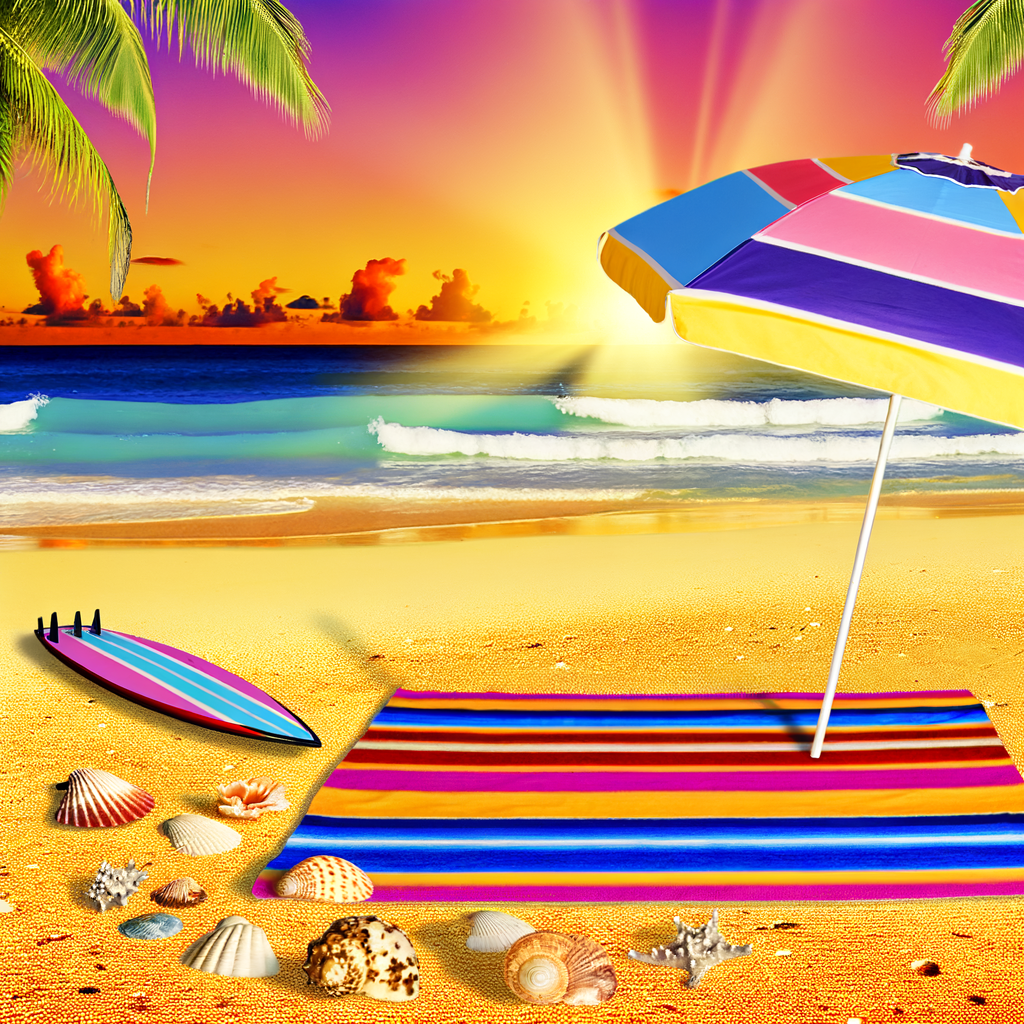

In [7]:
# Generate scene image, allowing some level of diversity
scene_name = scene_thinking(constraint=scene_constrain, temperature=1.5)

# Retrieve words aligned with the scene image
if same:
    word_list, _ = generate_noun_given_scene_aimodel(num=obj_count + 1, scene=scene_name,
                                                     temperature=temp_generate_noun_given_scene)
else:
    word_list, _ = generate_noun_given_scene_aimodel(num=obj_count, scene=scene_name,
                                                     temperature=temp_generate_noun_given_scene)
generate_image_given_scene(word_list, scene_name, image_name=init_img_path)

In [8]:
# generate the image based on the provided objects
scene_key_char = list([val for val in scene_name if val.isalpha() or val.isnumeric()])
scene_key = "".join(scene_key_char).lower()

scene_details = {
    "scene_name": scene_name,
    "word_list": word_list,
    "path": init_img_path
}

In [9]:
# Constraints to eliminate some objects already created
diversity_cond = ""

# Generate one irrelevant object based on the scene
correlated_obj = correlated_obj_thinking_aimodel(temperature=temp_correlated_obj_thinking, cond=diversity_cond)

# Generate the target object and disturbing object from the generated object pair
target_obj, disturbing_obj, target_attributes, disturbing_attributes \
    = correlated_example_create_aimodel(correlated_obj, attribute_category_list,
                                      save_prefix=save_loc)

As an alternative option, the users could load their own image from external resources as the scene image.

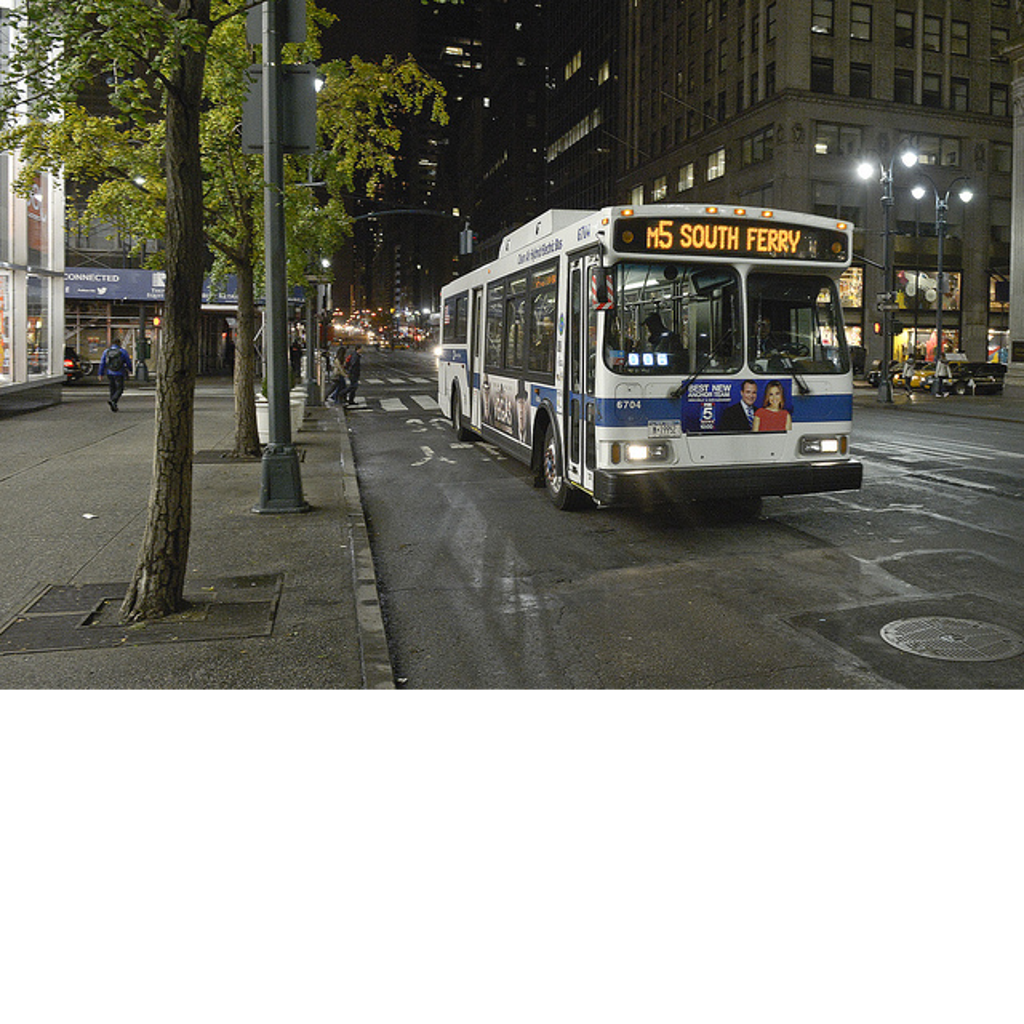

In [10]:
exteral_scene_path = os.path.join(exteral_path, "init.png")
shutil.copyfile(exteral_scene_path, init_img_path)
init_img = Image.open(init_img_path)
init_img

In [11]:
# Scene name, queried from dataset
scene_name = "Nighttime urban bus."
word_list, _ = generate_noun_given_scene_aimodel(num=obj_count, scene=scene_name,
                                                     temperature=temp_generate_noun_given_scene)

In [12]:
# Correlated objects, target object (for insertion) and disturbing object queried from the dataset with objects
target_obj = "person"
disturbing_obj = "smartphone"

In [13]:
# Declare hallucination case information through warning messages
logger.warning("[Input] scene constrain: " + str(scene_constrain))
logger.warning("[Generated] scene name: " + scene_name)
logger.warning("[Target Model Generated] relevant objects: " + str(word_list))
logger.warning("[Target Model Generated] target object (for addition attack): " + target_obj)
logger.warning(
    "[Target Model Generated] disturbance object (not exist, for correlation attack): " + disturbing_obj)

In [14]:
# Declare hallucination case information through warning messages
print("[Input] scene constrain: " + str(scene_constrain))
print("[Generated] scene name: " + scene_name)
print("[Target Model Generated] relevant objects: " + str(word_list))
print("[Target Model Generated] target object (for addition attack): " + target_obj)
print("[Target Model Generated] disturbance object (not exist, for correlation attack): " + disturbing_obj)

[Input] scene constrain: None
[Generated] scene name: Nighttime urban bus.
[Target Model Generated] relevant objects: ['bus', 'streetlight', 'passenger', 'seat', 'driver']
[Target Model Generated] target object (for addition attack): person
[Target Model Generated] disturbance object (not exist, for correlation attack): smartphone


### Phase 2: Paired Object Insertion

Generate the paired object image from the target and disturbing object name queried, segment contextual information from the scene image, insert the target object into the scene when leaving the disturbing object from insertion.

In [15]:
# Load the object detection model (Owl-ViT)
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [16]:
# generate list of detected objects
mask_img, mask_bbox = None, None
for word in word_list:
    text_input = "a photo of " + word
    mask_img, mask_bbox = object_detection(init_img_path, text_input, processor, model, mask_img,
                                           mask_bbox, save_prefix=save_loc)

As an alternative option, the users could load their own image from external resources as the object image.

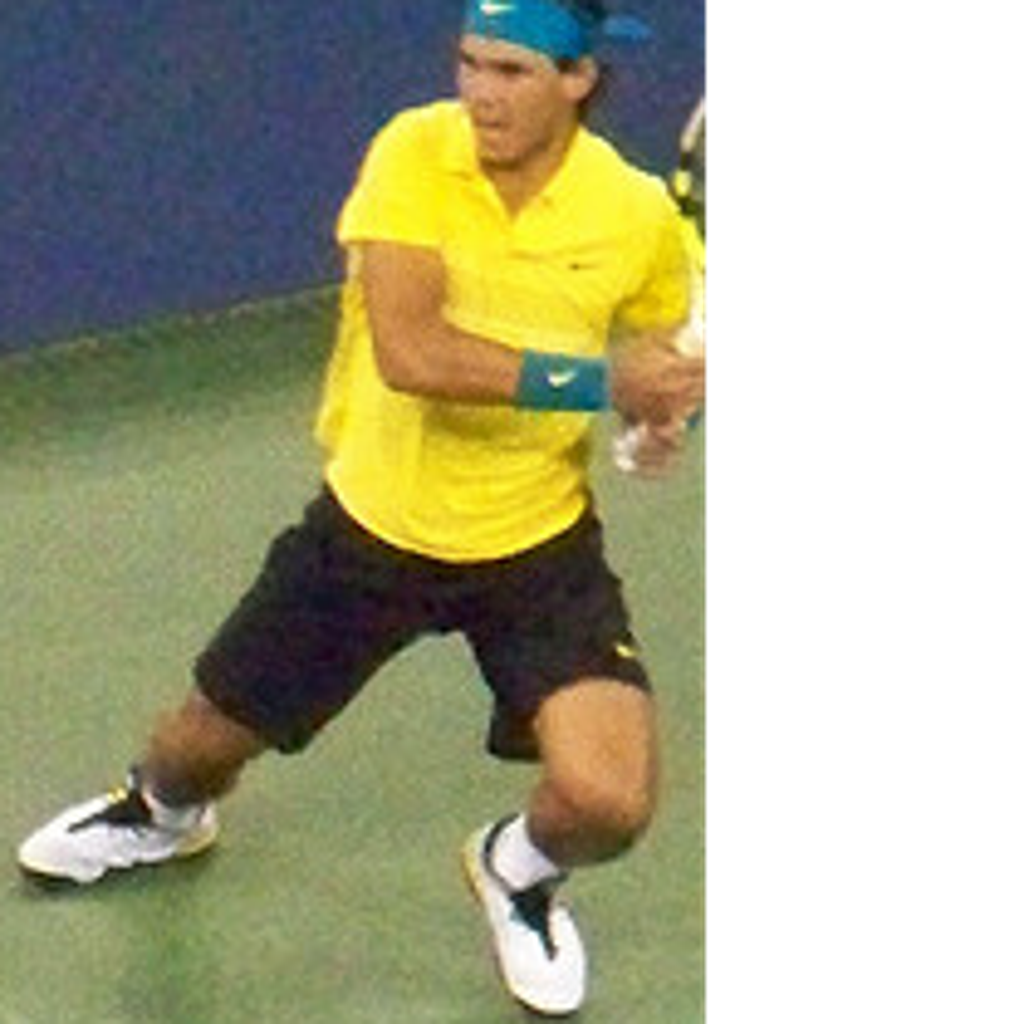

In [17]:
exteral_obj_path = os.path.join(exteral_path, "obj.png")
exteral_pure_obj_path = os.path.join(exteral_path, "pure_obj.png")
exteral_mask_obj_path = os.path.join(exteral_path, "mask_obj.png")

shutil.copyfile(exteral_obj_path, os.path.join(save_loc, "obj.png"))
shutil.copyfile(exteral_pure_obj_path, os.path.join(save_loc, "pure_obj.png"))
shutil.copyfile(exteral_mask_obj_path, os.path.join(save_loc, "mask_obj.png"))
obj_img = Image.open(exteral_obj_path)
obj_img

In [18]:
# add new item -- need to prepare mask_region_img.png, obj.png, pure_obj.png and obj_mask.png
result_img, irrelevant_obj_bbox = Addition_Image_Operation_VD_stitch_correlation(
    init_img_path=init_img_path, existing_bbox=mask_bbox, path_prefix=save_loc,
    out_image_name=result_img_path, add_object_size=object_size, overlapped_ratio=0.5,
    scene_img_raw_size=scene_img_raw_size)

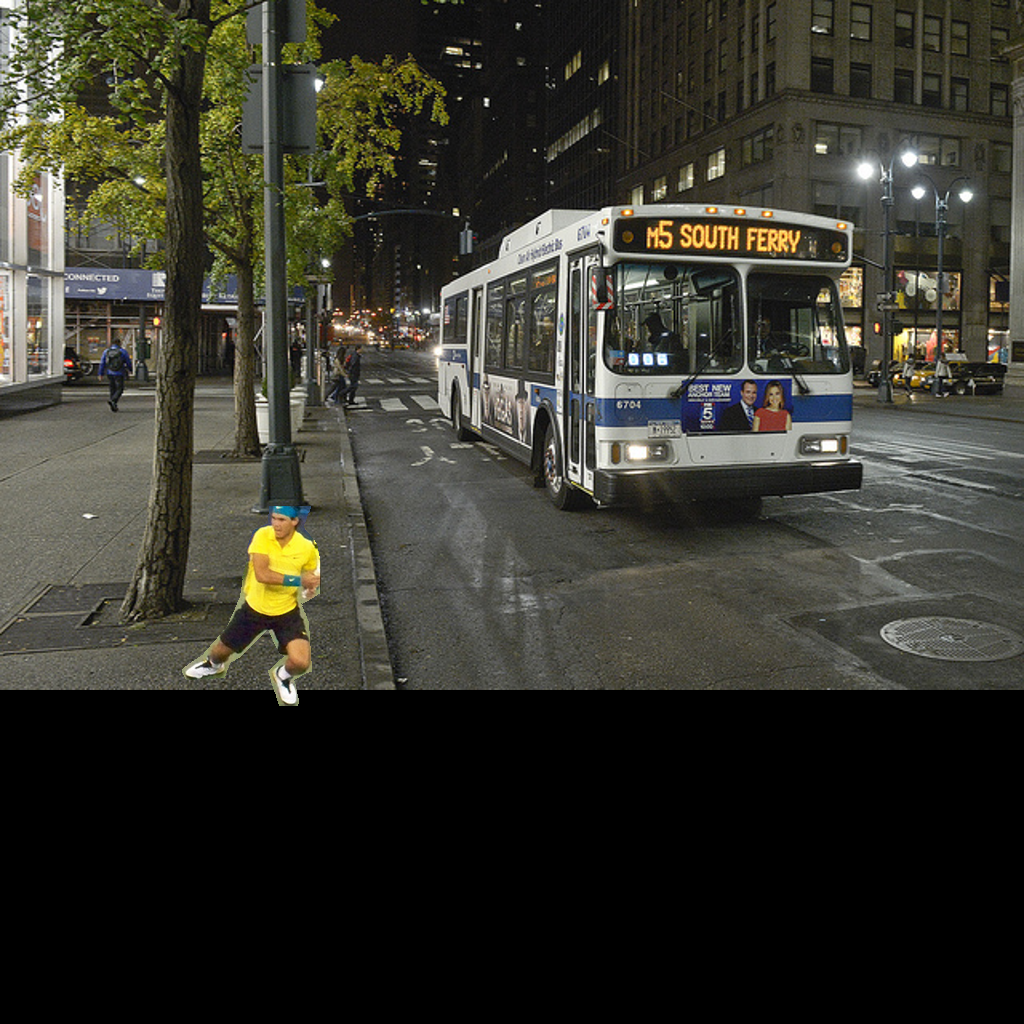

In [19]:
result_img

### Phase 3: Question Construction and Hallucination Detection 

Construct the existence and spatial relation questions and the corresponding ground truth for the inserted target object, along with the existence questions and the corresponding ground truth for the disturbing object, use evaluation model to detect hallucinations within the question-answer pair generated.

In [20]:
# Generate the ground truth of existence questions
ground_truth = gt_generation_aimodel(init_img_path, mask_bbox, scene_name, target_obj,
                                target_attributes, save_prefix=save_loc)

In [21]:
# List detected object name and captions
logger.warning("[Detection Model] detected objects: " + str(ground_truth["object_name"]))
logger.warning(
    "[Target Model Generated] detected object captions: " + str(ground_truth["object_description"]))

logger.warning("[Target Model Generated] irrelevant object caption: " + ground_truth[
    "irrelevant_object_description"])

In [22]:
# List detected object name and captions
print("[Detection Model] detected objects: " + str(ground_truth["object_name"]))
print(
    "[Target Model Generated] detected object captions: " + str(ground_truth["object_description"]))

print("[Target Model Generated] irrelevant object caption: " + ground_truth[
    "irrelevant_object_description"])

[Detection Model] detected objects: ['City transit bus.', 'Urban street lamp', 'Blurry motorcycle rider.', 'Computer hardware components.']
[Target Model Generated] detected object captions: ['Public city bus at night heading to South Ferry.', 'Tall metal street lamp with multiple illuminated spherical bulbs.', 'A blurred image of a motorcycle rider in motion.', 'Open computer case showing internal components and wiring.']
[Target Model Generated] irrelevant object caption: The person in the image is an athletic individual engaged in a sporting activity, possibly tennis, given the outfit and posture. The person is wearing a bright yellow t-shirt matched with black shorts, which suggests a team or sports club. Notably, the attire includes several sponsor logos. Additionally, accessories like a blue headband and wristbands complement the sporty look, indicating preparation for vigorous physical activity. The individual is captured in a dynamic pose, with their arms extended in what appea

In [23]:
# image level caption
result_caption = image_caption_aimodel(result_img_path)
ground_truth["result_description"] = result_caption
ground_truth["disturbing_object"] = disturbing_obj

In [24]:
logger.warning("[Target Model Generated] image-level caption: " + ground_truth["result_description"])

In [25]:
print("[Target Model Generated] image-level caption: " + ground_truth["result_description"])

[Target Model Generated] image-level caption: This image depicts an urban nighttime scene, likely in a busy city. A city bus, labeled "M5 South Ferry," is featured prominently in the scene, indicating it might be somewhere in New York City. The bus is on a street lined with trees and streetlights, and a few pedestrians can be seen in the background. There is also a person running on the sidewalk, wearing a yellow shirt and purple shorts, giving a dynamic element to the otherwise stationary scene. The environment appears wet, suggesting recent rain, and the street reflects the lights from street lamps and the bus. The overall atmosphere is lively yet subdued, typical of an urban setting after rain.


In [26]:
# Generate the ground truth of spatial relations
ground_truth = spatial_gt_generation(ground_truth, irrelevant_obj_bbox, mask_bbox, enable=True)

spatial_relation_str = ""
for i in range(len(ground_truth["spatial_relation"])):
    spatial_relation_str += str(ground_truth["spatial_relation"][i]) + "; "

In [27]:
logger.warning(
    "[Target Model Generated] Spatial Relations (w.r.t. detected objects): " + spatial_relation_str)
logger.warning("[Target Model Generated] Irrelevant-detected Object Distances): " + str(
    ground_truth["spatial_distance"]))

In [28]:
print(
    "[Target Model Generated] Spatial Relations (w.r.t. detected objects): " + spatial_relation_str)
print("[Target Model Generated] Irrelevant-detected Object Distances): " + str(
    ground_truth["spatial_distance"]))

[Target Model Generated] Spatial Relations (w.r.t. detected objects): ['left', 'down']; ['left', 'down']; ['down']; ['left', 'down']; 
[Target Model Generated] Irrelevant-detected Object Distances): [452.9657823721346, 704.7779792246633, 242.0433845408711, 585.0307684216275]


In [29]:
# Evaluate answers for existence questions based on the given evaluation models
existence_results, exi_case_result = evaluation_existence_given_pred_model(result_img_path, ground_truth,
                                                                result_caption, vqa_model_func=vqa_aimodel, 
                                                               logger=logger, debug=True, notebook_print=True)

######
[ATTACK] Adding new irrelevant object 'person' -- existence
[Obj] person
[Q] Is there a person in this image?
[Pred] Yes, there is a person in this image, shown jogging on the sidewalk, wearing yellow clothing. Additionally, there are a few more people visible in the background of the scene.
[GT] There is a person.
[Eval (same or not)] 1
[Attack Failed] Added irrelevant object detected.
######
[ATTACK] Adding new irrelevant object 'person' with image-level caption -- existence
[Obj] person
[Q] We have an image depicting This image depicts an urban nighttime scene, likely in a busy city. A city bus, labeled "M5 South Ferry," is featured prominently in the scene, indicating it might be somewhere in New York City. The bus is on a street lined with trees and streetlights, and a few pedestrians can be seen in the background. There is also a person running on the sidewalk, wearing a yellow shirt and purple shorts, giving a dynamic element to the otherwise stationary scene. The environ

In [30]:
logger.warning("[Evaluation Model] Existence Eval Results: " + existence_results)

In [31]:
print("[Evaluation Model] Existence Eval Results: " + existence_results)

[Evaluation Model] Existence Eval Results: Existence Attack Success


In [32]:
# Evaluate answers for correlated objects existence questions based on the given evaluation models
correlated_results, corr_case_result = evaluation_correlated_existence_pred_model(result_img_path,
                                                                             ground_truth,
                                                                             vqa_model_func=vqa_aimodel,
                                                                             logger=logger, debug=True, notebook_print=True)

######
[ATTACK] Asking about non-existing, correlated object 'smartphone' only -- existence
[Existing Obj] person
[Correlated Obj] smartphone
[Q] Is there a/an smartphone in this image?
[Pred] There is no visible smartphone in the image. The scene captures a city street at night with a bus and a man jogging, but no smartphones are clearly visible in anyone's hands or anywhere else in the scene.
[GT] There is no smartphone.
[Eval (same or not)] 1
######
[ATTACK] Asking about non-existing, correlated object 'smartphone' given existing object person -- existence
[Existing Obj] person
[Correlated Obj] smartphone
[Q] We have person in this image. Is there a/an smartphone in this image as well?
[Pred] Yes, there is a person in the image who appears to be holding a smartphone in their hand while walking.
[GT] There is no smartphone.
[Eval (same or not)] 0
[Attack Success] Non-existing correlated object mistakenly detected given existing object.
######
[ATTACK] Asking about non-existing, corre

In [33]:
logger.warning("[Evaluation Model] Correlated Object Existence Eval Results: " + correlated_results)

In [34]:
print("[Evaluation Model] Correlated Object Existence Eval Results: " + correlated_results)

[Evaluation Model] Correlated Object Existence Eval Results: Correlated Object Existence Attack Success


In [35]:
# Evaluate answers for spatial relation questions based on the given evaluation models
spatial_relation_results, spa_case_result = evaluation_spatial_relation_give_pred_model(result_img_path,
                                                                                ground_truth, vqa_model_func=vqa_aimodel,
                                                                                logger=logger, debug=True, notebook_print=True)

######
[ATTACK] Determine spatial relation between the irrelevant object 'person' and the existing object: City transit bus.
[Obj] person
[Q] Is the person on the left of a/an City transit bus. in this image, given their center positions?Where City transit bus. is the one that Public city bus at night heading to South Ferry..
[Pred] In the image, the person on the left side is a runner wearing a yellow top and purple shorts, running on a sidewalk. The person is positioned more to the left of the center of the image and not directly near the city transit bus, which is on the street to the person's right. The bus is labeled with "M5 South Ferry" indicating it is a public city bus.
[GT] person is on the left of a/an City transit bus. in this imageWhere City transit bus. is the one that Public city bus at night heading to South Ferry..
[Eval (same or not)] 1
[Attack Failed] The spatial relation between the added irrelevant object and the existing object City transit bus. (#2 closest) is co

In [36]:
logger.warning("[Evaluation Model] Spatial Relation Eval Results: " + spatial_relation_results)

In [37]:
print("[Evaluation Model] Spatial Relation Eval Results: " + spatial_relation_results)

[Evaluation Model] Spatial Relation Eval Results: Spatial Relation Attack Success
